In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f
from sklearn.model_selection import train_test_split

In [26]:
class MLP(nn.Module):
    def __init__(self, architecture, activation, dropout_p=0.0):
        super(MLP, self).__init__() # chama o construtor da classe pai.
        self.layers = nn.ModuleList()
        self.activation_name = activation
        self.dropout_p = dropout_p

        for i in range(len(architecture) - 1):
            self.layers.append(nn.Linear(architecture[i], architecture[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.activation_name == 'relu':
                x = f.relu(x)
            elif self.activation_name == 'tanh':
                x = torch.tanh(x)
            if self.dropout_p > 0:
                x = f.dropout(x, p=self.dropout_p, training=self.training)
        x = self.layers[-1](x)  # última camada (sem ativação)
        return x


# retorna um número entre 0 e 1 representando o quão bom foi. 0 = pior resultado (muito longe), 1 = acertou
def binary_accuracy(preds, labels, threshold=0.5):
    probs = torch.sigmoid(preds)
    preds_class = (probs > threshold).float()
    return (preds_class == labels).float().mean().item()

# Retorna a proporção de exemplos que a rede previu corretamente.
def multiclass_accuracy(preds, labels):
    preds_class = preds.argmax(dim=1)                # escolhe classe com maior logit
    return (preds_class == labels).float().mean().item()




In [41]:
def train_model_with_validation(model, optimizer, criterion, x_train, y_train, x_val, y_val, epochs, patience, show_logs=False):
    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):

        # Treinamento
        model.train() # Coloca a rede em modo treinamento. (ativa dropout, etc)
        outputs = model(x_train) # faz o forward pass — aplica as camadas da rede nos dados de treino.
        loss = criterion(outputs, y_train) # calcula a função de perda com as saídas da rede e os rótulos reais.
        optimizer.zero_grad() # zera os gradientes antigos acumulados (importante!).
        loss.backward() # calcula os gradientes da perda em relação aos pesos (backpropagation).
        optimizer.step() # atualiza os pesos da rede com base nos gradientes.

        # Avaliação
        model.eval() # coloca a rede em modo avaliação (desativa dropout, etc).
        with torch.no_grad(): # desativa o rastreamento de gradientes — melhora a performance e reduz uso de memória.
            train_acc = binary_accuracy(outputs, y_train) # Mede a acurácia no conjunto de treinamento
            
            val_outputs = model(x_val) # Obtém os outputs do conjunto de validação.
            val_loss = criterion(val_outputs, y_val) # Calcula novamente a perda, agora com os dados de validação.
            val_acc = binary_accuracy(val_outputs, y_val) # Mede a acurácia no conjunto de validação.

        # Armazena as métricas obtidas pelo treinamento/validação no dicionário history.
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)

        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)
        
        if show_logs:
            print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

        # Early stopping - with validation set
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restaura o melhor modelo salvo.
    if best_model is not None:
        model.load_state_dict(best_model)
    return model, history

def evaluate_model(model, x, y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        loss = criterion(outputs, y)
        acc = binary_accuracy(outputs, y)
    return loss.item(), acc


In [42]:
def plota_treinamento():
    epochs = range(1, len(history['train_loss']) + 1)

    # Figura com 2 subplots (loss e accuracy)
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    if 'val_loss' in history and history['val_loss']:
        plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    if 'val_acc' in history and history['val_acc']:
        plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def plota_regiao_decisao(model, X, Y, resolution=0.01, title='Região de Decisão'):
    """
    Plota a região de decisão do modelo treinado (MLP não-linear).
    
    Parâmetros:
    - model: rede treinada (PyTorch)
    - X: dados de entrada (numpy array)
    - Y: rótulos (0 ou 1)
    - resolution: resolução da malha para o grid (quanto menor, mais detalhado)
    """
    from matplotlib.colors import ListedColormap

    # Garante que o modelo está em modo avaliação
    model.eval()

    # Define os limites do grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Gera grid de pontos
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Prepara a entrada do modelo (tensores 2D -> 2 colunas)
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.from_numpy(grid).float()

    # Faz predição com a rede
    with torch.no_grad():
        outputs = model(grid_tensor)
        probs = torch.sigmoid(outputs).numpy()
        Z = (probs > 0.5).astype(int).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

    # Pontos reais
    X_pos = X[Y == 1]
    X_neg = X[Y == 0]
    plt.scatter(X_pos[:, 0], X_pos[:, 1], c='blue', label='Classe 1', edgecolor='k')
    plt.scatter(X_neg[:, 0], X_neg[:, 1], c='red', label='Classe 0', edgecolor='k')

    plt.title(title)
    plt.xlabel('Atributo 1')
    plt.ylabel('Atributo 2')
    plt.legend()
    plt.grid(True)
    plt.show()


In [43]:
dataset_treinamento = '..\\perceptron_datasets\\train_dataset1.csv'
dataset_testes = '..\\perceptron_datasets\\test_dataset1.csv'

df_train_loaded = pd.read_csv(dataset_treinamento)
df_test_loaded = pd.read_csv(dataset_testes)

x_train = df_train_loaded.drop('label', axis=1).values
y_train = df_train_loaded['label'].values

x_test = df_test_loaded.drop('label', axis=1).values
y_test = df_test_loaded['label'].values


# Divide o conjunto de treino em 90% treino e 10% validação
x_test_split, x_val_split, y_test_split, y_val_split = train_test_split(
    x_test,
    y_test,
    test_size=0.5, # 15% do conjunto de treino vai ser agora o conjunto de validação.
    random_state=42,
    stratify=y_test) # Mantém a proporção das classes na reprodução (gera sub-conjuntos bem representativos)

# AJustes necessários nos ddos para usar um classificador binário. Motivo: Os resultados estão como -1 e 1, mas queremos usar 0 e 1 !!!
y_train = (y_train == 1).astype(float)
y_val_split = (y_val_split == 1).astype(float)
y_test_split = (y_test_split == 1).astype(float)


# Trasformando os numpy arrays em tensores (requisito do torch).
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1) # o view transforma em uma matriz com n vetores de  tamanho 1 (exigência do pytorch)

x_val_tensor = torch.from_numpy(x_val_split).float()
y_val_tensor = torch.from_numpy(y_val_split).float().view(-1, 1)

x_test_tensor = torch.from_numpy(x_test_split).float()
y_test_tensor = torch.from_numpy(y_test_split).float().view(-1, 1) # o view transforma em uma matriz com n vetores de  tamanho 1 (exigência do pytorch)


#### Experimento 1
Camadas = 2, 3, 1

Função de perda (ou de custo): Mede o quão ruim está a previsão da rede em relação à resposta esperada. Calcula o erro da rede. É calculado no forward e usado no backpropagation para ajustar os pesos. Utilizando: Binary cross entropy (medida antes da função de ativação da saída)

Patience: A partir de quantas iterações sem melhoria do erro eu devo parar

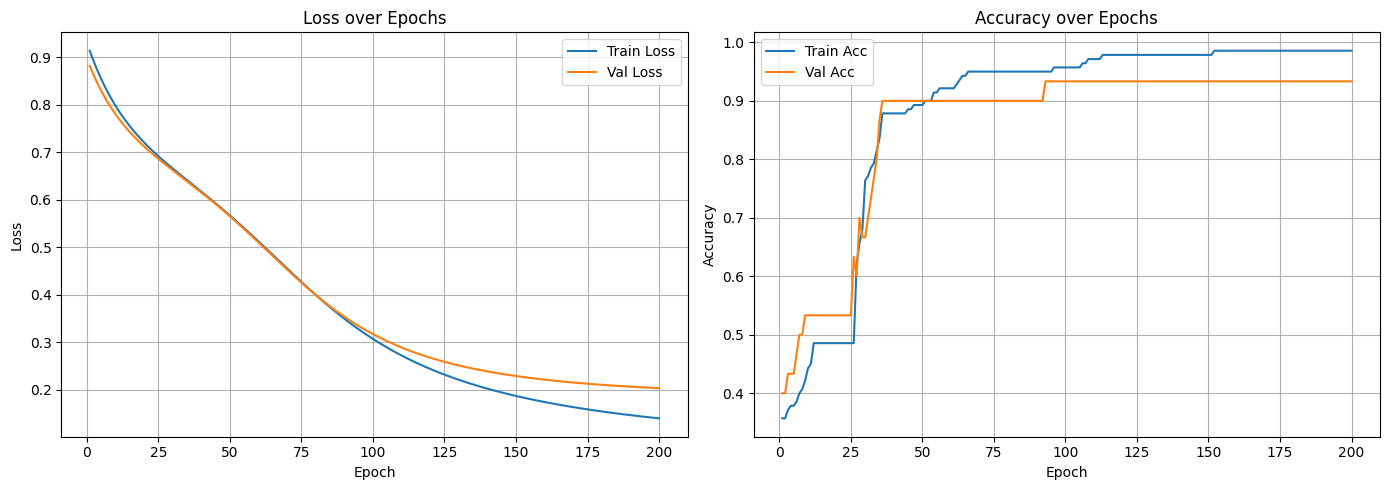

Resultados --- conjunto de testes: 
 Loss: 0.1466, Acurácia: 0.9667


In [45]:
camadas = [2, 3, 1]
fx_ativacao = 'tanh'
probabilidade_dropout = 0.0 # sem dropout

modelo = MLP(camadas, fx_ativacao, probabilidade_dropout)

optimizer = torch.optim.SGD(modelo.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
epochs = 200
patience = 10
#criterion = nn.CrossEntropyLoss()  # ou BCEWithLogitsLoss para binário

# Sem validação
model_trained, history = train_model_with_validation(modelo, 
                                                     optimizer, 
                                                     criterion, 
                                                     x_train_tensor, 
                                                     y_train_tensor,
                                                     x_val_tensor,
                                                     y_val_tensor, 
                                                     epochs, 
                                                     patience)

plota_treinamento()

loss, acc = evaluate_model(model_trained, x_test_tensor, y_test_tensor, criterion)

print(f"Resultados --- conjunto de testes: \r\n Loss: {loss:.4f}, Acurácia: {acc:.4f}")


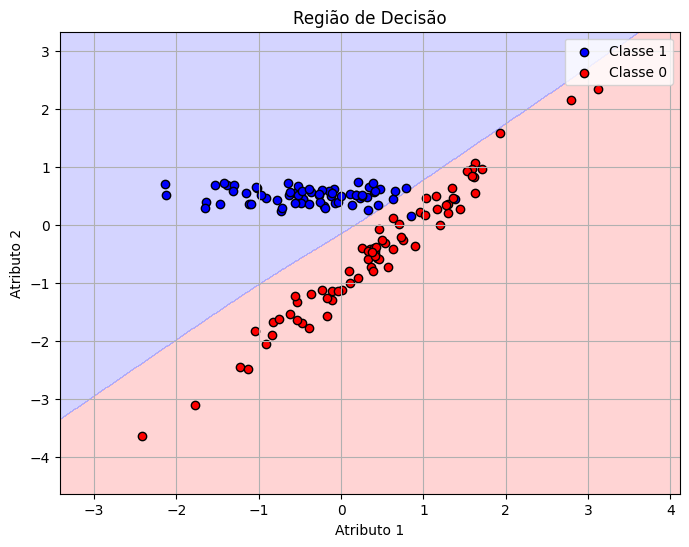

In [46]:
plota_regiao_decisao(model_trained, x_train_tensor.numpy(), y_train_tensor.numpy().flatten())

### Salvar e carregar o modelo
Caso queira salvar o modelo para carregar posteriormente, utilize:

In [ ]:
# Para salvar:
torch.save(model.state_dict(), 'modelo_treinado_ex1.pth')

# Para carregar:
# Recrie a arquitetura igual à do treinamento
model = MLP([2, 3, 1], activation='tanh')
model.load_state_dict(torch.load('modelo_treinado.pth'))
model.eval()  # coloca em modo de avaliação (sem dropout, etc)
